In [3]:
from sklearn.utils import Tags

In [5]:
# Import library yang dibutuhkan untuk eksplorasi dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind,probplot,shapiro,spearmanr,kruskal
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, recall_score, f1_score
from scipy.stats import kruskal
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load dataset
df = pd.read_csv('data_customer_lifetime_value.csv')
df.head()

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492


<div style="padding:10px; 
            color:#ffff;
            margin:10px;
            font-size:180%;
            text-align:center;
            display:fill;
            background-color: #213555;
            overflow:hidden;
            font-weight:500">1. Data Preprocessing & Modeling</div>

****

In [9]:
df_clean = df.drop_duplicates()

In [11]:
categorical_cols = ["Vehicle Class", "Coverage", "Renew Offer Type", 
                    "EmploymentStatus", "Marital Status", "Education"]
numerical_cols = ["Number of Policies", "Monthly Premium Auto", "Total Claim Amount", "Income"]
target_col = "Customer Lifetime Value"

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

coverage_mapping = [{'col' : 'Coverage',
                   'mapping' : {None : 0, 'Basic' : 1,'Extended' : 2, 'Premium' : 3}}]
rot_mapping = [{'col' : 'Renew Offer Type',
                'mapping' : {None : 0, 'Offer1' : 1,'Offer2' : 2, 'Offer3' : 3, 'Offer4' : 4}}]
education_mapping = [{"col" : "Education",
                      'mapping' : {None : 0, 'High School or Below' : 1,'College' : 2, 'Bachelor' : 3, 'Master' : 4, 'Doctor' : 5}}]


preprocessor = ColumnTransformer(
    transformers=[
    ('onehot', OneHotEncoder(drop = 'first'), ['Vehicle Class', 'EmploymentStatus', 'Marital Status']), # Onehot encoder untuk data nominal
    ('coverage_ordinal', ce.OrdinalEncoder(mapping = coverage_mapping), ['Coverage']),                   # Ordinal encoder untuk data ordinal
    ('rot_ordinal', ce.OrdinalEncoder(mapping = rot_mapping), ['Renew Offer Type']),                     # ---------------//-----------------
    ('education_ordinal', ce.OrdinalEncoder(mapping = education_mapping), ['Education']),
    ('scaler', RobustScaler(), ['Number of Policies', 'Total Claim Amount']),
    ('scaler2', MaxAbsScaler(), ['Income'])
], remainder = "passthrough")

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Output the processed shape
X_train.shape, X_test.shape

((4040, 18), (1011, 18))

# Optimized MLP Model with Mixed Precision  

## Overview  
This is a **Multi-Layer Perceptron (MLP) model** optimized for **regression tasks**. It utilizes **mixed precision training**, an **AdamW optimizer**, and **Huber loss** to enhance performance and efficiency, especially on **RTX 30 series GPUs**.

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, mixed_precision
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Enable Mixed Precision for Faster Training
mixed_precision.set_global_policy('mixed_float16')  # FP16 computation for RTX 30 series

# Define Optimized MLP Model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(1024),  # Larger neurons
    layers.Activation("swish"),
    layers.BatchNormalization(),
    layers.Dropout(0.1),  # Increased dropout for regularization

    layers.Dense(512),
    layers.Activation("swish"),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    layers.Dense(256),
    layers.Activation("swish"),
    layers.BatchNormalization(),

    layers.Dense(128),
    layers.Activation("swish"),

    layers.Dense(64),
    layers.Activation("swish"),

    layers.Dense(1, dtype="float32")  # Ensure output is float32
])

# Compile Model with AdamW & Huber Loss
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss=keras.losses.Huber(delta=0.01),
    metrics=["mae"]
)

# Callbacks for Training Optimization
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train Model with Larger Batch Size
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300, batch_size=128,  # Larger batch for better GPU utilization
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 81.6176 - mae: 8161.7666 - val_loss: 76.5244 - val_mae: 7652.4404 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 79.7139 - mae: 7971.3989 - val_loss: 70.6457 - val_mae: 7064.5791 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 69.1985 - mae: 6919.8535 - val_loss: 70.6880 - val_mae: 7068.8022 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 50.2315 - mae: 5023.1528 - val_loss: 47.2240 - val_mae: 4722.4077 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 36.6559 - mae: 3665.5933 - val_loss: 42.0969 - val_mae: 4209.6982 - learning_rate: 0.0010
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 30.9429 - mae: 3094.2939 - val_loss: 42.1135 - val_mae: 4211.3511 - learning_rate: 0.0010
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 29.3707 - mae: 2937.0754 - val_loss: 42.

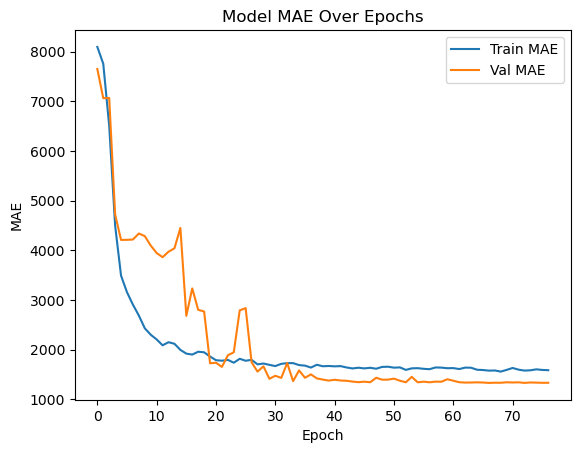

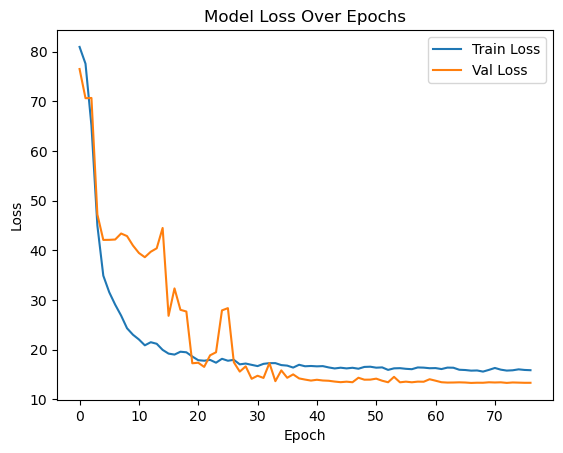

In [62]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Model MAE Over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [76]:
# Evaluate Model
loss, mae = model.evaluate(X_train, y_train)
y_pred_train = model.predict(X_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
print(f"Train RMSE: {train_rmse}")
print(f"Train MAPE: {train_mape:.2f}%")

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.8186 - mae: 1481.8655
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE: 4352.736157060192
Train MAPE: 7.76%


In [64]:
loss, mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Compute RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print Results
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test MAPE: {mape}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.1083 - mae: 1310.8354
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MAE: 1329.1724853515625
Test RMSE: 4457.809685959814
Test MAPE: 7.448739799993372%


<div style="padding:10px; 
            color:#ffff;
            margin:10px;
            font-size:180%;
            text-align:center;
            display:fill;
            background-color: #213555;
            overflow:hidden;
            font-weight:500">2. Code Explanation</div>

****

### **1. Mixed Precision for Faster Training**  
```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, mixed_precision

# Enable Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
Enables half-precision (FP16) computation for faster training on modern GPUs.
Reduces memory usage, allowing for larger batch sizes and improved performance.


### 2. MLP Architecture with Swish Activation
#### Key Features:

- **Swish activation** instead of ReLU for **better gradient flow** and **faster convergence**.
- **Batch Normalization** to stabilize training and prevent **internal covariate shift**.
- **Dropout layers (0.1)** to **prevent overfitting** and improve **generalization**.

---

### AdamW Optimizer & Huber Loss  

```python
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss=keras.losses.Huber(delta=0.01),
    metrics=["mae"]
)




#### Why?

- AdamW optimizer improves weight decay handling, making training more stable.
- Huber loss (with delta = 0.01) reduces sensitivity to outliers while maintaining regression accuracy.

---

### 3. Callbacks for Efficient Training  

```python
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

#### Key Benefits:  

- **Early Stopping** prevents **overfitting** by stopping training if **validation loss doesn’t improve for 10 epochs**.  
- **ReduceLROnPlateau** lowers the **learning rate** if validation loss stagnates, ensuring **smoother convergence**.  

---

### 5. Training with a Larger Batch Size  

```python
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=300, batch_size=128,  # Larger batch size for better GPU utilization
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


#### Why?

- Batch size = 128 maximizes GPU utilization while maintaining stability.
- 300 epochs allow for thorough training, but early stopping ensures efficiency.

In [ ]:
# import pickle

# # Save model as HDF5
# model.save("mlp_model2.h5")

# # Save predictions to pickle
# with open("predictions2.pkl", "wb") as f:
#     pickle.dump(y_pred, f)

# print("Model and predictions saved successfully!")

In [ ]:
# with open("predictions.pkl", "rb") as f:
#     loaded_predictions = pickle.load(f)

<div style="padding:10px; 
            color:#ffff;
            margin:10px;
            font-size:180%;
            text-align:center;
            display:fill;
            background-color: #213555;
            overflow:hidden;
            font-weight:500">3. Model Explanation</div>

****

In [44]:
import shap

# Create a SHAP DeepExplainer
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

PermutationExplainer explainer: 1012it [08:55,  1.86it/s]                                                              


In [45]:
onehot_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(['Vehicle Class', 'EmploymentStatus', 'Marital Status'])

ordinal_features = ['Coverage', 'Renew Offer Type', 'Education']

numerical_features = ['Number of Policies', 'Total Claim Amount', 'Income']

feature_names = list(onehot_features) + ordinal_features + numerical_features + list(X.columns.difference(['Vehicle Class', 'EmploymentStatus', 'Marital Status', 'Coverage', 'Renew Offer Type', 'Education', 'Number of Policies', 'Total Claim Amount', 'Income']))

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

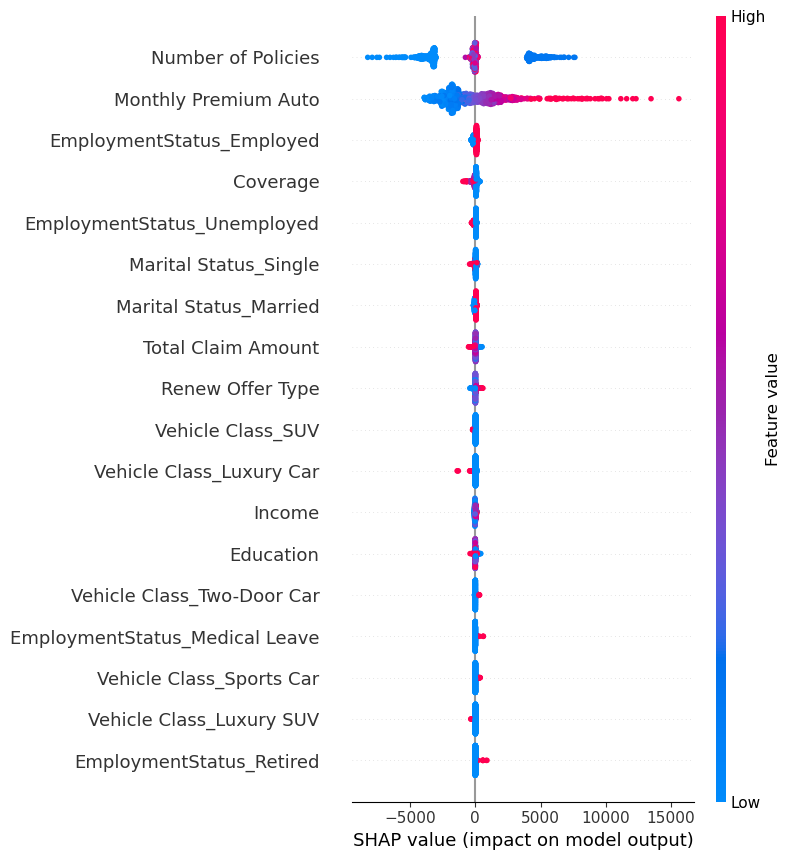

In [46]:
shap.summary_plot(shap_values, X_test_df, feature_names=feature_names)

In [47]:
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance = (shap_importance / shap_importance.sum()) * 100

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)  

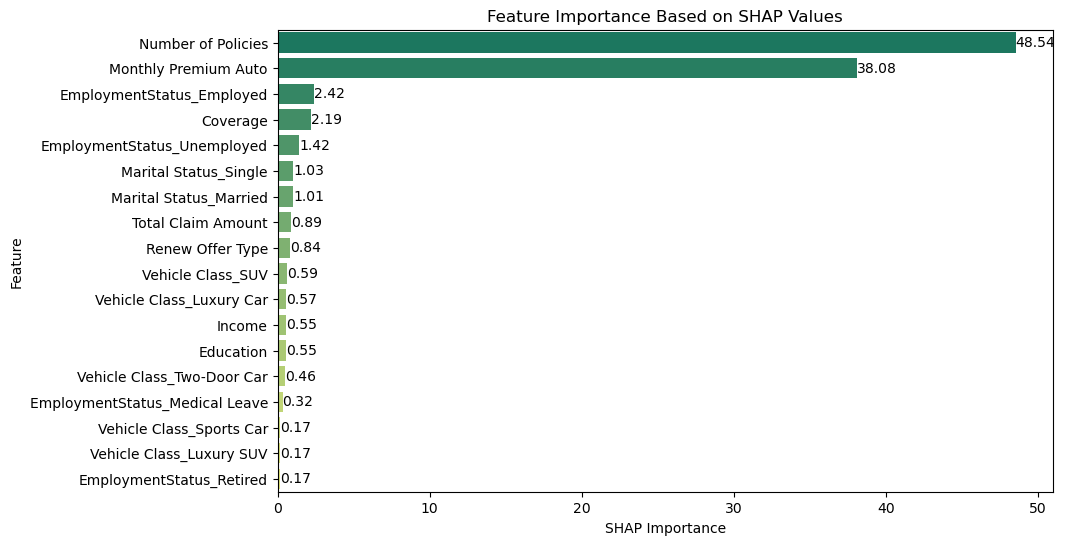

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='summer')

plt.title('Feature Importance Based on SHAP Values')
plt.xlabel('SHAP Importance')
plt.ylabel('Feature')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                va='center', 
                ha='left', 
                color='black')

plt.show()

### Most Influential Features:
- **Number of Policies** and **Monthly Premium Auto** remain the top influential features in the model, similar to Random Forest.
- **EmploymentStatus_Employed** and **Coverage** appear more prominent in MLP compared to Random Forest.

### Decreased Impact of Income:
- In MLP, **Income** moves down in the feature importance ranking, indicating that MLP is less sensitive to variations in income compared to Random Forest.

### More Concentrated SHAP Distribution:
- In MLP, most SHAP values tend to cluster around zero with a narrower distribution. This suggests that MLP might be more "conservative" in making extreme predictions or more evenly distributing feature influence.

### Vehicle Class Features Remain Less Impactful:
- Features like **Vehicle Class_Luxury Car**, **Sports Car**, **SUV**, etc., still show minimal impact on model output. This is consistent with Random Forest, implying that both models agree vehicle type is not a primary driver of prediction.

---

## 📊 Comparison: Random Forest vs MLP (Deep Learning)

| Aspect                        | Random Forest                                  | MLP (Deep Learning)                                |
|-----------------------------|--------------------------------------------------|----------------------------------------------------|
| **Top Influential Features** | Number of Policies, Monthly Premium, Income     | Number of Policies, Monthly Premium, Employment Status |
| **SHAP Value Distribution**  | More dispersed (larger extreme range)           | More concentrated near zero                        |
| **Income Impact**            | High and non-linear                             | Relatively lower                                   |
| **Employment Status Impact** | Less prominent                                  | More significant in MLP                            |
| **Model Response**           | Non-linear and highly interpretable             | Smoother generalization, but sometimes too subtle  |
| **Overfitting Potential**    | Tends to overfit on small datasets              | Requires proper tuning to avoid under/overfitting  |


In [49]:
y_pred = model.predict(X_test).flatten() 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [50]:
data = {
    'Predicted Customer Lifetime Value': y_test,
    'Actual Customer Lifetime Value': y_pred
}

# Create DataFrame
tes = pd.DataFrame(data)

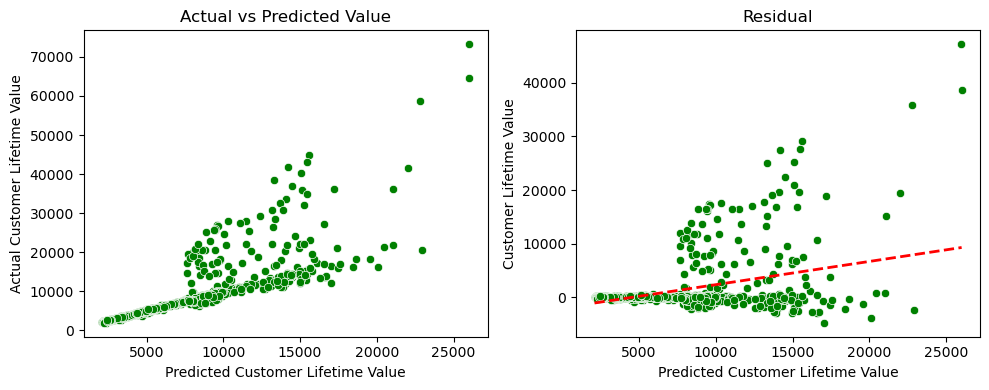

In [51]:
fig, axs =  plt.subplots(1, 2, figsize=(10, 4), facecolor = 'none')

sns.scatterplot(y = y_test, x = y_pred, ax = axs[0], color='green')
axs[0].set_xlabel('Predicted Customer Lifetime Value')
axs[0].set_ylabel('Actual Customer Lifetime Value')
axs[0].set_title('Actual vs Predicted Value')

sns.scatterplot(x = y_pred, y = y_test - y_pred, ax = axs[1], color = 'green')
axs[1].set_xlabel('Predicted Customer Lifetime Value')
axs[1].set_ylabel('Residual')
axs[1].set_title('Residual')

sns.regplot(x = y_pred, y = y_test - y_pred, ax = axs[1], scatter=False, color='r', 
            line_kws={'color': 'red', 'lw': 2, 'ls': '--'}, ci=None)

# plt.savefig('my_plot16.png', dpi=300, transparent=True)
fig.tight_layout()
plt.show()

### Actual vs Predicted Value Plot
- **Slightly Tighter Fit at Lower Range:** Predictions follow the diagonal well in lower ranges but begin to deviate as values increase.
- **Underestimation Evident at High CLV:** High actual values are still underpredicted, indicating the model struggles with extreme values.
- **Less Spread Compared to RF:** MLP appears to capture mid-range values slightly better, with fewer extreme deviations.

---
### Residual Plot
- **Upward Trending Residual Line:** The red line slightly trends upward, indicating increasing residuals as predicted values increase — a sign of potential bias or underfitting in high-value predictions.
- **Clustered Residuals in Low-Mid Range:** Residuals are concentrated in lower ranges, suggesting better performance in that region.
- **Higher Spread at High Predictions:** Residuals show increasing spread at higher predicted values, hinting at underperformance in predicting high CLV customers.

---

### Comparison:
| Aspect                             | Random Forest                               | MLP (Deep Learning)                             |
|-----------------------------------|---------------------------------------------|-------------------------------------------------|
| Correlation (Actual vs Predicted) | Strong diagonal trend                       | Decent fit, more accurate in low-mid ranges     |
| High CLV Handling                 | Tends to underpredict                       | Also underpredicts, with higher residuals       |
| Residual Distribution             | Well-centered and random                    | Increasing error trend at high predictions      |
| Residual Regression Line          | Flat (ideal)                                | Slightly upward (possible bias or drift)        |

---

**Conclusion:**  
While both models perform reasonably well, **Random Forest shows more balanced residual behavior and robustness across ranges**, whereas **MLP performs better on average ranges but struggles more on high-value predictions** and may benefit from further tuning or advanced architecture.


In [80]:
y_pred.mean()

6805.9243

In [82]:
y_test.mean()

7748.800642782393

## Business Insight from MLP Forecast

### Forecast Summary:
- **Actual Customer Lifetime Value (CLV):** 7,748  
- **Forecasted CLV (MLP Model):** 6,805  
- **Difference:** -$943 (Underestimation by 12%)

### Interpretation:
- The MLP model provides a reasonably accurate estimation of customer value.
- However, it **slightly underestimates the actual CLV**, which could affect business decisions that rely solely on predicted values.
- This indicates that the model is **well-calibrated overall**, but may require improvement in **capturing higher-value customer segments** more precisely.

### Business Implications:
- Underestimating high-value customers may lead to **missed opportunities** in marketing, loyalty programs, or personalized offers.
- Using this forecast for customer segmentation or budgeting may cause **resource misallocation**, especially if high-value customers are classified into lower tiers.

### Recommendations:
- **Fine-tune the MLP model** to improve its sensitivity toward higher CLV ranges.
- **Combine CLV predictions with additional customer behavior indicators** for better decision-making.
- Consider **monitoring high-value customers separately** to avoid under-engagement.
